In [1]:
from pyomo.environ import *
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# https://quantivity.wordpress.com/2011/02/21/why-log-returns/

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### EDA

In [2]:
# get price data from yfinance 
asset_equity = ['SPY']
asset_fixed_income = ['TIP']
asset_commodities = ['GLD']
asset_reits = ['VNQ']
# asset_crypto = ['BTC-USD']

all_asset = asset_equity + asset_fixed_income + asset_commodities + asset_reits
data = yf.download(tickers = all_asset, start = '2019-01-01', end = '2022-01-01', interval = '1d')['Close'].reset_index()
data = data.dropna()
data.head()

[*********************100%***********************]  4 of 4 completed


,Date,GLD,SPY,TIP,VNQ
0,2018-12-31,121.250000,249.919998,109.510002,74.570000
1,2019-01-02,121.330002,250.179993,109.680000,72.949997
2,2019-01-03,122.430000,244.210007,110.320000,73.459999
3,2019-01-04,121.440002,252.389999,110.089996,74.320000
4,2019-01-07,121.860001,254.380005,110.019997,75.050003


In [3]:
data.to_csv("asset_prices.csv")

In [4]:
# calculate log return 
for asset in all_asset:
    data[asset + '_return'] = data[asset].pct_change().apply(lambda x: np.log(1 + x))
columns = [asset + '_return' for asset in all_asset]
returns = data.dropna()[columns].reset_index(drop=True)
returns.head()

,SPY_return,TIP_return,GLD_return,VNQ_return
0,0.001040,0.001551,0.000660,-0.021964
1,-0.024152,0.005818,0.009025,0.006967
2,0.032947,-0.002087,-0.008119,0.011639
3,0.007854,-0.000636,0.003453,0.009775
4,0.009351,0.000818,-0.002712,0.020442


In [5]:
returns.describe()

,SPY_return,TIP_return,GLD_return,VNQ_return
count,757.000000,757.000000,757.000000,757.000000
mean,0.000848,0.000218,0.000454,0.000584
std,0.013940,0.003911,0.009661,0.017005
min,-0.115887,-0.029081,-0.055190,-0.195136
25%,-0.003629,-0.001485,-0.004143,-0.005237
50%,0.001547,0.000388,0.000912,0.001613
75%,0.007086,0.001943,0.005628,0.007288
max,0.086731,0.043573,0.047390,0.086147


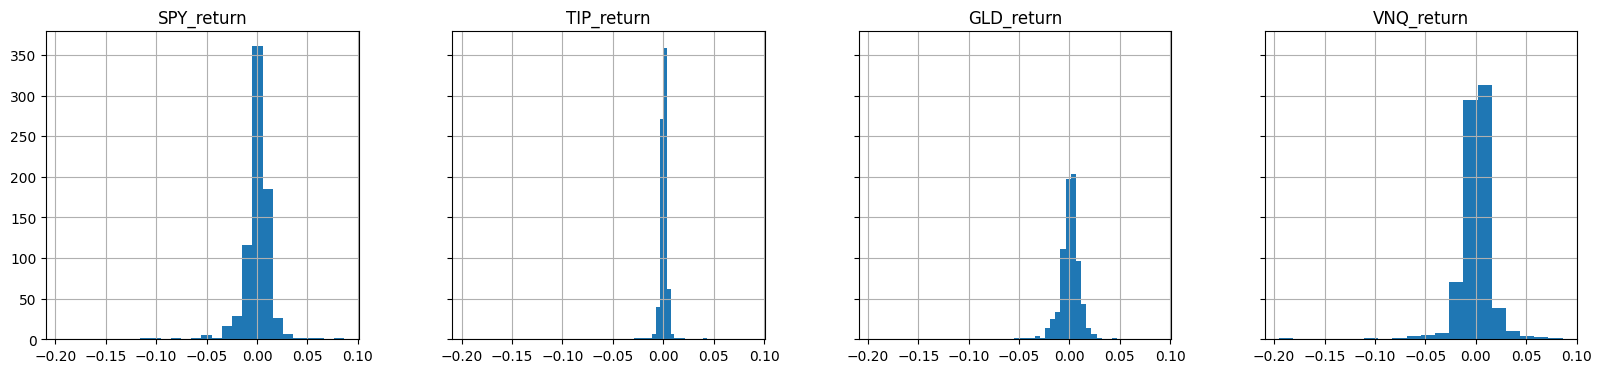

In [6]:
# plot the histogram and visualize the distribution 
returns.hist(column=returns.columns, bins=20, figsize=(25,4), sharex='True', sharey=True, layout=(1,5), )
plt.show()

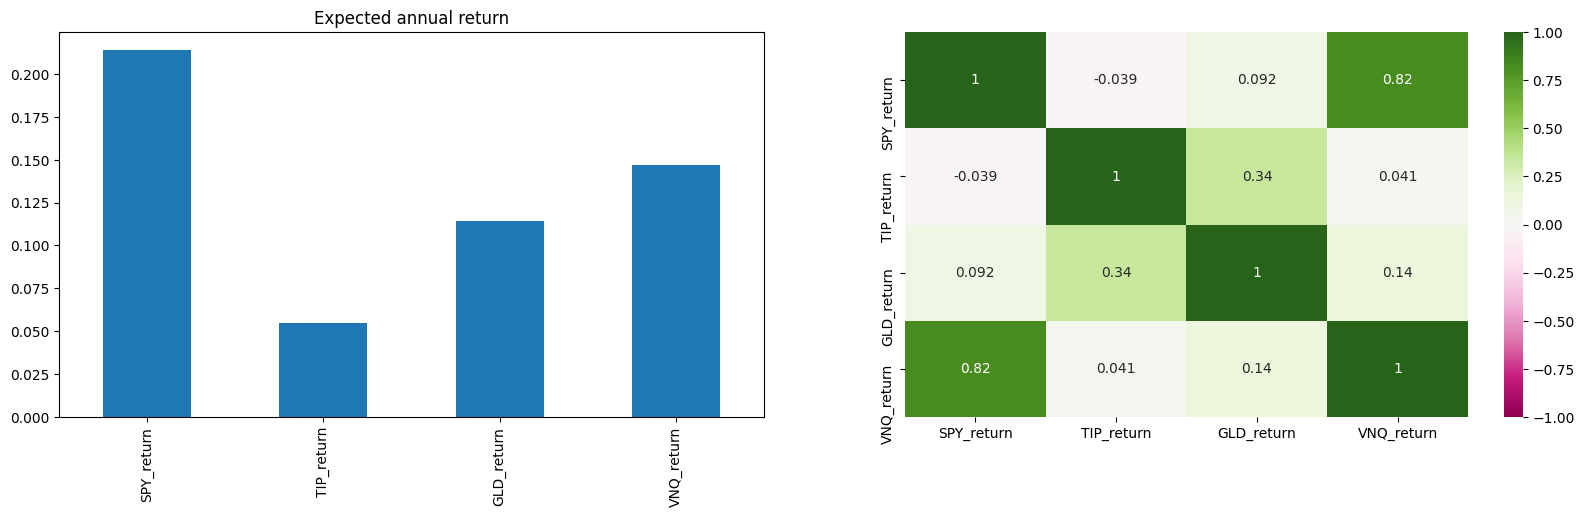

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

expected_annual_return = returns.mean()*252
expected_annual_return.plot(kind='bar', ax = ax1, title='Expected annual return')

sns.heatmap(returns.corr(),annot=True, vmin=-1, vmax=1, cmap='PiYG', ax= ax2)
plt.show()

### Optimization 

In [8]:
model = ConcreteModel("Multiobjective Optimization")

#### Sets

In [9]:
model.i = Set(initialize=all_asset, doc='selection ratio')
model.i.pprint()

i : selection ratio
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    4 : {'SPY', 'TIP', 'GLD', 'VNQ'}


#### Decision variable

In [10]:
model.X=Var(model.i, bounds=(0,1))
model.X.pprint()

X : Size=4, Index=i
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    GLD :     0 :  None :     1 : False :  True :  Reals
    SPY :     0 :  None :     1 : False :  True :  Reals
    TIP :     0 :  None :     1 : False :  True :  Reals
    VNQ :     0 :  None :     1 : False :  True :  Reals


#### Parameters

In [11]:
# expected annual return
expected_annual_return_dict = dict(zip(all_asset, expected_annual_return))
model.r = Param(model.i, initialize=lambda model, i: expected_annual_return_dict[i], doc = 'expected annual return')
model.r.pprint()

r : expected annual return
    Size=4, Index=i, Domain=Any, Default=None, Mutable=False
    Key : Value
    GLD :  0.11437375212304715
    SPY :   0.2137471698639397
    TIP : 0.055042418878702225
    VNQ :   0.1471181110700744


In [12]:
# covariance 
cov = returns.cov().values

def get_covariance(model, i, j):
    return cov[all_asset.index(i)][all_asset.index(j)]

model.cov = Param(model.i, model.i, rule = get_covariance, doc='covariance matrix')
model.cov.pprint()

cov : covariance matrix
    Size=16, Index=cov_index, Domain=Any, Default=None, Mutable=False
    Key            : Value
    ('GLD', 'GLD') :  9.333553584829427e-05
    ('GLD', 'SPY') : 1.2441370910748731e-05
    ('GLD', 'TIP') : 1.2788410431952524e-05
    ('GLD', 'VNQ') : 2.2900604230531085e-05
    ('SPY', 'GLD') : 1.2441370910748731e-05
    ('SPY', 'SPY') : 0.00019432016971336093
    ('SPY', 'TIP') : -2.118673906688453e-06
    ('SPY', 'VNQ') : 0.00019475034405293942
    ('TIP', 'GLD') : 1.2788410431952524e-05
    ('TIP', 'SPY') : -2.118673906688453e-06
    ('TIP', 'TIP') : 1.5293906509298986e-05
    ('TIP', 'VNQ') :  2.748120118790737e-06
    ('VNQ', 'GLD') : 2.2900604230531085e-05
    ('VNQ', 'SPY') : 0.00019475034405293942
    ('VNQ', 'TIP') :  2.748120118790737e-06
    ('VNQ', 'VNQ') : 0.00028918599611488753


In [13]:
# epsilon-constraint
model.e = Param(initialize=1.0, mutable=True)
model.e.pprint()

e : Size=1, Index=None, Domain=Any, Default=None, Mutable=True
    Key  : Value
    None :   1.0


#### Constraints

In [14]:
# sum of all porfolio ratio = 1
model.C1 = Constraint(expr = sum(model.X[i] for i in model.i) == 1)
model.C1.pprint()

C1 : Size=1, Index=None, Active=True
    Key  : Lower : Body                              : Upper : Active
    None :   1.0 : X[SPY] + X[TIP] + X[GLD] + X[VNQ] :   1.0 :   True


In [15]:
# risk <= epsilon constraint
model.C2 = Constraint(expr = sum([model.X[i]*model.X[j]*model.cov[i,j] for i in model.i for j in model.i]) <= model.e, doc='risk upper bounded by epsilon')
model.C2.pprint()

C2 : risk upper bounded by epsilon
    Size=1, Index=None, Active=True
    Key  : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       : Upper : Active
    None :  -Inf : X[SPY]*X[SPY]*0.00019432016971336093 + X[SPY]*X[TIP]*-2.118673906688453e-06 + X[SPY]*X[GLD]*1.2441370910748731e-05 + X[SPY]*X[VNQ]*0.00019475034405293942 + X[TIP]*X[SPY]*-2.118673906688453e-06 + X[TIP]*X[TIP]*1.5293906509298986e-05 + X[TIP]*X[GLD]*1.27884

#### Objective functions

In [16]:
# objective 1 : maximize return
model.obj1 = Objective(expr = sum(model.X[i]*model.r[i] for i in model.i), sense=maximize)
model.obj1.pprint()

obj1 : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 0.2137471698639397*X[SPY] + 0.055042418878702225*X[TIP] + 0.11437375212304715*X[GLD] + 0.1471181110700744*X[VNQ]


In [17]:
# objective 2 : minimize risk 
model.obj2 = Objective(expr = sum([model.X[i]*model.X[j]*model.cov[i,j] for i in model.i for j in model.i]), sense=minimize)
model.obj2.pprint()

obj2 : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : X[SPY]*X[SPY]*0.00019432016971336093 + X[SPY]*X[TIP]*-2.118673906688453e-06 + X[SPY]*X[GLD]*1.2441370910748731e-05 + X[SPY]*X[VNQ]*0.00019475034405293942 + X[TIP]*X[SPY]*-2.118673906688453e-06 + X[TIP]*X[TIP]*1.5293906509298986e-05 + X[TIP]*X[GLD]*1.2788410431952524e-05 + X[TIP]*X[VNQ]*2.748120118790737e-06 + X[GLD]*X[SPY]*1.2441370910748731e-05 + X[GLD]*X[TIP]*1.2788410431952524e-05 + X[GLD]*X[GLD]*9.333553584829427e-05 + X[GLD]*X[VNQ]*2.2900604230531085e-05 + X[VNQ]*X[SPY]*0.00019475034405293942 + X[VNQ]*X[TIP]*2.748120118790737e-06 + X[VNQ]*X[GLD]*2.2900604230531085e-05 + X[VNQ]*X[VNQ]*0.00028918599611488753


#### Solve objective 1: maximize return 

In [18]:
# deactivate objective 2 and constraint 2
model.obj2.deactivate()
model.C2.deactivate()
SolverFactory('ipopt').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 4
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.14.3\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.1548161506652832
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [19]:
max_risk = value(model.obj2)
print("Solution:", [round(model.X[i](3)) for i in model.X])
print(f"Objective value 1: expected annual return of {round(model.obj1()*100, 2)}%")
print(f"Objective value 2: expected risk {round(model.obj2(), 6)}")

Solution: [1, 0, 0, 0]
Objective value 1: expected annual return of 21.37%
Objective value 2: expected risk 0.000194


#### Solve objective 2: minimize risk 

In [20]:
# deactivate objective 2 and constraint 2
model.obj2.activate()
model.obj1.deactivate()
model.C2.deactivate()
SolverFactory('ipopt').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 4
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.14.3\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.13362979888916016
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [21]:
min_risk = value(model.obj2)
print("Solution:", [round(model.X[i](3)) for i in model.X])
print(f"Objective value 1: expected annual return of {round(model.obj1()*100, 2)}%")
print(f"Objective value 2: expected risk {round(model.obj2(), 6)}")

Solution: [0, 1, 0, 0]
Objective value 1: expected annual return of 6.86%
Objective value 2: expected risk 1.4e-05


#### Epsilon constraint method

In [22]:
print(f'Maximum risk level at {round(max_risk, 6)} and minimum risk level at {round(min_risk, 6)}.')

Maximum risk level at 0.000194 and minimum risk level at 1.4e-05.


In [23]:
e_constraints = np.linspace(min_risk, max_risk, 50)
print(e_constraints)

[1.38620085e-05 1.75448278e-05 2.12276472e-05 2.49104665e-05
 2.85932858e-05 3.22761052e-05 3.59589245e-05 3.96417439e-05
 4.33245632e-05 4.70073825e-05 5.06902019e-05 5.43730212e-05
 5.80558405e-05 6.17386599e-05 6.54214792e-05 6.91042985e-05
 7.27871179e-05 7.64699372e-05 8.01527565e-05 8.38355759e-05
 8.75183952e-05 9.12012146e-05 9.48840339e-05 9.85668532e-05
 1.02249673e-04 1.05932492e-04 1.09615311e-04 1.13298131e-04
 1.16980950e-04 1.20663769e-04 1.24346589e-04 1.28029408e-04
 1.31712227e-04 1.35395047e-04 1.39077866e-04 1.42760685e-04
 1.46443505e-04 1.50126324e-04 1.53809143e-04 1.57491963e-04
 1.61174782e-04 1.64857601e-04 1.68540421e-04 1.72223240e-04
 1.75906059e-04 1.79588879e-04 1.83271698e-04 1.86954517e-04
 1.90637337e-04 1.94320156e-04]


In [24]:
# fix objective 2(risk) as constraint 
# in every iteration, increase the upper bound of risk (epsilon)
# store the results of each iteration 
model.obj2.deactivate()
model.obj1.activate()
model.C2.activate()

solutions = []
obj1 = []
obj2 = []
for e in e_constraints: 
    model.e = e
    SolverFactory('ipopt').solve(model)
    solutions.append([model.X[i]() for i in model.X])
    obj1.append(value(model.obj1))
    obj2.append(value(model.obj2))

#### Plot efficient frontier 

In [25]:
# create random portfolios
random_portfolio = np.random.random((500, 4))
sum = random_portfolio.sum(axis=1)
for i in range(len(random_portfolio)):
    for j in range(len(random_portfolio[0])):
        random_portfolio[i][j] = random_portfolio[i][j]/sum[i]

random_return = np.sum([[random_portfolio[i][j]*expected_annual_return[j] for j in range(0, len(all_asset))] for i in range(len(random_portfolio))], axis=1)

random_risk = []
for portfolio in random_portfolio:
    risk = np.sum([portfolio[i]*portfolio[j]*cov[i,j] for i in range(len(all_asset)) for j in range(len(all_asset))])
    random_risk.append(risk)

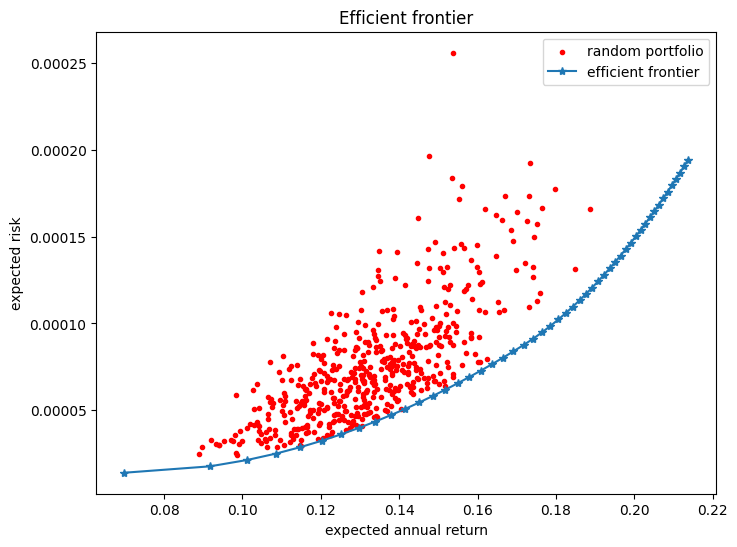

In [26]:
# plot efficient frontier
fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(random_return, random_risk, marker = '.', color = 'r', label='random portfolio')
plt.plot(obj1, obj2, marker = '*', label='efficient frontier')
plt.xlabel('expected annual return')
plt.ylabel('expected risk')
plt.title('Efficient frontier')
plt.legend()
plt.show()

In [27]:
# store results in dataframe 
results = pd.DataFrame(solutions, columns = all_asset)
results['expected annual return'] = obj1
results['expected risk'] = obj2

pd.set_option("display.precision", 3)
results

,SPY,TIP,GLD,VNQ,expected annual return,expected risk
0,0.086,8.949e-01,1.868e-02,-8.719e-09,0.070,1.387e-05
1,0.192,7.033e-01,1.050e-01,2.197e-08,0.092,1.755e-05
2,0.238,6.195e-01,1.428e-01,2.361e-08,0.101,2.124e-05
3,0.273,5.552e-01,1.717e-01,2.725e-08,0.109,2.492e-05
4,0.303,5.010e-01,1.962e-01,2.704e-08,0.115,2.860e-05
5,0.329,4.532e-01,2.177e-01,2.683e-08,0.120,3.229e-05
6,0.353,4.100e-01,2.372e-01,2.665e-08,0.125,3.597e-05
7,0.375,3.703e-01,2.551e-01,2.649e-08,0.130,3.965e-05
8,0.395,3.333e-01,2.717e-01,2.633e-08,0.134,4.333e-05
9,0.414,2.986e-01,2.874e-01,2.619e-08,0.138,4.702e-05
